In [3]:
import numpy as np
from scipy.stats import gamma, scoreatpercentile, multivariate_normal
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.formula.api as smf

import pandas as pd
import seaborn as sns


### Collider bias


When we build a statistical model, we need to think about whether our variables make sense in terms of causal relations. There is a phenomenon called *collider bias* that can occur in one particular situation, where a variable is added as a regressor when it is a common effect of another regressor and the outcome variable.  (When one variable has two causal inputs it is referred to as a *collider*, hence the name).

Here we will use a real-world example, using data from the [Fifa 23 Players Dataset](https://www.kaggle.com/datasets/sanjeetsinghnaik/fifa-23-players-dataset) which contains data on a large number of soccer players.



In [4]:
fifa_df = pd.read_csv('https://raw.githubusercontent.com/poldrack/ResearchMethods/main/Demos/Categorization/Fifa_23_Players_Data.csv')
fifa_df = fifa_df.rename(columns={'Height(in cm)': 'height',
                  'Weight(in kg)': 'weight',
                  'Shot Power': 'shotpower',
                  'Shooting Total': 'shooting',
                  'Defending Total': 'defending',
                  'Value(in Euro)': 'value',
                  'Sprint Speed': 'speed'})

In [5]:
fifa_df.head()

,Known As,Full Name,Overall,Potential,value,Positions Played,Best Position,Nationality,Image Link,Age,...,LM Rating,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating
0,L. Messi,Lionel Messi,91,91,54000000,RW,CAM,Argentina,https://cdn.sofifa.net/players/158/023/23_60.png,35,...,91,88,91,67,66,67,62,53,62,22
1,K. Benzema,Karim Benzema,91,91,64000000,"CF,ST",CF,France,https://cdn.sofifa.net/players/165/153/23_60.png,34,...,89,84,89,67,67,67,63,58,63,21
2,R. Lewandowski,Robert Lewandowski,91,91,84000000,ST,ST,Poland,https://cdn.sofifa.net/players/188/545/23_60.png,33,...,86,83,86,67,69,67,64,63,64,22
3,K. De Bruyne,Kevin De Bruyne,91,91,107500000,"CM,CAM",CM,Belgium,https://cdn.sofifa.net/players/192/985/23_60.png,31,...,91,91,91,82,82,82,78,72,78,24
4,K. Mbappé,Kylian Mbappé,91,95,190500000,"ST,LW",ST,France,https://cdn.sofifa.net/players/231/747/23_60.png,23,...,92,84,92,70,66,70,66,57,66,21


Take a sample and assess the relation between shotpower and defending.

Text(0.5, 1.0, 'Random sample of 1000 players')

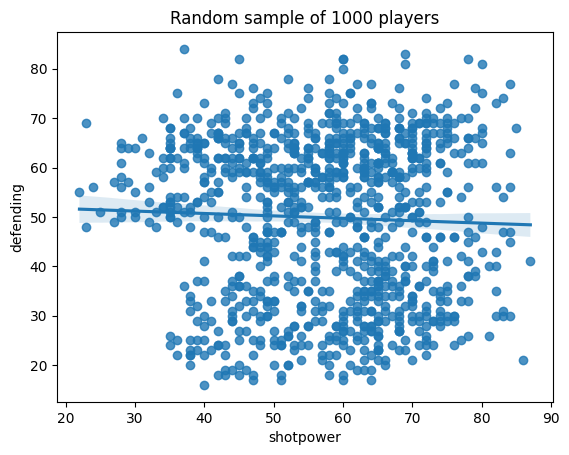

In [12]:
n = 1000
fifa_sample = fifa_df.sample(n=n, random_state=42)
sns.regplot(data=fifa_sample, x='shotpower', y='defending')
plt.title(f'Random sample of {n} players')

In [13]:
fifa_model = sm.OLS(fifa_sample['defending'], sm.add_constant(fifa_sample['shotpower'])).fit()
print(fifa_model.summary())

                            OLS Regression Results                            
Dep. Variable:              defending   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.523
Date:                Sun, 03 Aug 2025   Prob (F-statistic):              0.217
Time:                        10:35:20   Log-Likelihood:                -4200.9
No. Observations:                1000   AIC:                             8406.
Df Residuals:                     998   BIC:                             8416.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.6505      2.328     22.612      0.0

Now add overall rating to the model

In [14]:
fifa_model = sm.OLS(fifa_sample['defending'], sm.add_constant(fifa_sample[['shotpower', 'Overall']])).fit()
print(fifa_model.summary())

                            OLS Regression Results                            
Dep. Variable:              defending   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     116.5
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           3.40e-46
Time:                        10:35:27   Log-Likelihood:                -4096.6
No. Observations:                1000   AIC:                             8199.
Df Residuals:                     997   BIC:                             8214.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.0445      4.627     -2.171      0.0

### Selection bias


Pick the top 200 highest valued players.

Text(0.5, 1.0, 'Top 200 players')

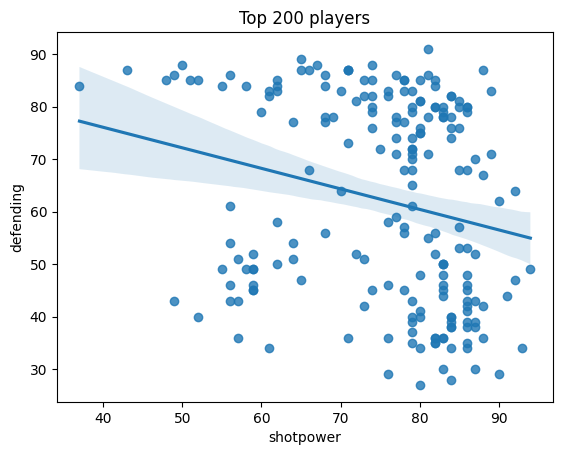

In [43]:
top_200_players = fifa_df.sort_values(by='Overall', ascending=False).head(200)
sns.regplot(data=top_200_players, x='shotpower', y='defending')
plt.title('Top 200 players')

In [44]:
fifa_model = sm.OLS(top_200_players['defending'], sm.add_constant(top_200_players['shotpower'])).fit()
print(fifa_model.summary())

                            OLS Regression Results                            
Dep. Variable:              defending   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     10.84
Date:                Thu, 07 Mar 2024   Prob (F-statistic):            0.00118
Time:                        12:25:14   Log-Likelihood:                -868.91
No. Observations:                 200   AIC:                             1742.
Df Residuals:                     198   BIC:                             1748.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         91.7051      9.064     10.117      0.0

<Axes: xlabel='shotpower', ylabel='defending'>

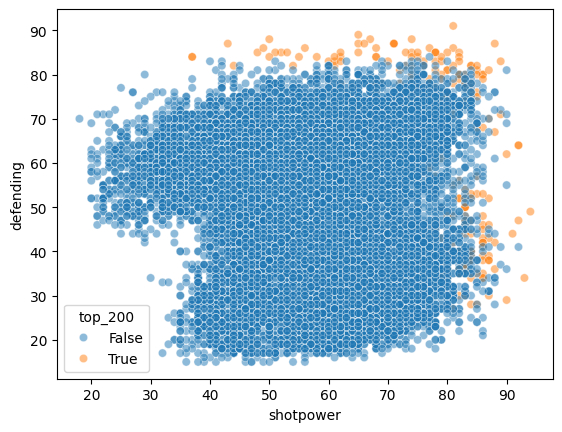

In [51]:
fifa_df['top_200'] = fifa_df.Overall >= top_200_players.Overall.min()
sns.scatterplot(data=fifa_df, x='shotpower', y='defending', hue='top_200', alpha=0.5)

In [49]:
fifa_df.query(f'Overall >= {top_200_players.Overall.min()}')

,Known As,Full Name,Overall,Potential,value,Positions Played,Best Position,Nationality,Image Link,Age,...,LM Rating,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating
0,L. Messi,Lionel Messi,91,91,54000000,RW,CAM,Argentina,https://cdn.sofifa.net/players/158/023/23_60.png,35,...,91,88,91,67,66,67,62,53,62,22
1,K. Benzema,Karim Benzema,91,91,64000000,"CF,ST",CF,France,https://cdn.sofifa.net/players/165/153/23_60.png,34,...,89,84,89,67,67,67,63,58,63,21
2,R. Lewandowski,Robert Lewandowski,91,91,84000000,ST,ST,Poland,https://cdn.sofifa.net/players/188/545/23_60.png,33,...,86,83,86,67,69,67,64,63,64,22
3,K. De Bruyne,Kevin De Bruyne,91,91,107500000,"CM,CAM",CM,Belgium,https://cdn.sofifa.net/players/192/985/23_60.png,31,...,91,91,91,82,82,82,78,72,78,24
4,K. Mbappé,Kylian Mbappé,91,95,190500000,"ST,LW",ST,France,https://cdn.sofifa.net/players/231/747/23_60.png,23,...,92,84,92,70,66,70,66,57,66,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,S. Berghuis,Steven Berghuis,82,82,29500000,"CAM,RW",CAM,Netherlands,https://cdn.sofifa.net/players/200/260/23_60.png,30,...,82,81,82,68,66,68,63,54,63,21
273,A. Lopes,Anthony Lopes,82,82,16000000,GK,GK,Portugal,https://cdn.sofifa.net/players/199/482/23_60.png,31,...,35,34,35,33,34,33,33,33,33,82
274,L. Muriel,Luis Muriel,82,82,25500000,ST,ST,Colombia,https://cdn.sofifa.net/players/199/110/23_60.png,31,...,82,74,82,60,54,60,55,47,55,20
275,W. Zaha,Wilfried Zaha,82,82,30000000,"LW,CF",LW,Côte d'Ivoire,https://cdn.sofifa.net/players/198/717/23_60.png,29,...,82,75,82,66,62,66,61,54,61,21
